In [1]:
import pandas as pd
import numpy as np
from env import user, password, host
#import wrangle
import prepare
from scipy import stats
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Acquire

In [3]:
url = f"mysql+pymysql://{user}:{password}@{host}/zillow"
# this query brings in all the columns necessary to ask the questions posed by the zillow team  
query = """
            
SELECT parcelid, bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, taxamount, assessmentyear, regionidcounty,regionidzip, fips, transactiondate
FROM properties_2017

LEFT JOIN propertylandusetype USING(propertylandusetypeid)

JOIN predictions_2017 USING(parcelid)

WHERE propertylandusedesc IN ("Single Family Residential",                       
                              "Inferred Single Family Residential")
                              AND (transactiondate BETWEEN '2017-05-01' AND '2017-08-31');
                              
                              """
    
df = pd.read_sql(query, url)
df

,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,taxamount,assessmentyear,regionidcounty,regionidzip,fips,transactiondate
0,11721753,3.0,2.0,1316.0,205123.0,2627.48,2016.0,3101.0,95997.0,6037.0,2017-07-21
1,11289917,3.0,2.0,1458.0,136104.0,2319.90,2016.0,3101.0,97318.0,6037.0,2017-06-23
2,11705026,2.0,1.0,1421.0,35606.0,543.69,2016.0,3101.0,96018.0,6037.0,2017-06-30
3,14269464,4.0,3.0,2541.0,880456.0,9819.72,2016.0,1286.0,96958.0,6059.0,2017-06-01
4,11446756,3.0,2.0,1491.0,107110.0,1399.27,2016.0,3101.0,96162.0,6037.0,2017-08-23
...,...,...,...,...,...,...,...,...,...,...,...
28119,11991766,6.0,2.0,2634.0,878190.0,12766.88,2016.0,3101.0,95985.0,6037.0,2017-08-31
28120,14011468,4.0,1.5,1187.0,465999.0,5552.68,2016.0,1286.0,96180.0,6059.0,2017-08-31
28121,14453399,5.0,3.0,3015.0,852813.0,11662.88,2016.0,1286.0,96983.0,6059.0,2017-08-31
28122,11128688,5.0,3.0,2992.0,1120000.0,13663.03,2016.0,3101.0,96356.0,6037.0,2017-08-31


In [4]:
# I need to prepare one df for answering the questions posed and a 2nd df name df2 that is for exploring and modeling

In [5]:
df.info()
# these are all the correct datatype

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28124 entries, 0 to 28123
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      28124 non-null  int64  
 1   bedroomcnt                    28124 non-null  float64
 2   bathroomcnt                   28124 non-null  float64
 3   calculatedfinishedsquarefeet  28077 non-null  float64
 4   taxvaluedollarcnt             28123 non-null  float64
 5   taxamount                     28123 non-null  float64
 6   assessmentyear                28124 non-null  float64
 7   regionidcounty                28124 non-null  float64
 8   regionidzip                   28107 non-null  float64
 9   fips                          28124 non-null  float64
 10  transactiondate               28124 non-null  object 
dtypes: float64(9), int64(1), object(1)
memory usage: 2.4+ MB


Feature                             Description

'assessmentyear':	                The year of the property tax assessment 
'bathroomcnt':   	                Number of bathrooms in home including fractional bathrooms
'bedroomcnt':   	                Number of bedrooms in home 
'calculatedfinishedsquarefeet': 	Calculated total finished living area of the home 
'parcelid':                     	Unique identifier for parcels (lots) 
'regionidcounty':                	County in which the property is located
'regionidzip':                  	Zip code in which the property is located
'taxamount':                        The total property tax assessed for that assessment year
'taxvaluedollarcnt':             	The total tax assessed value of the parcel

- I chose to use the column regionidzip instead of fips because this holds the actual zipcode
- I chose to keep parcelid so I could use it as the index 
- I chose to use calculatedfinishedsquarefeet because all of the other squarefeet features did not include the amount that would be advertised with the house which would only be the finished sqft
- I brought in the assessmentyear in order to only capture homes in the year of 2017
- Last I brought in transaction date to limit the dataset to only those homes with tranactions in the "hot months" May through August

In [6]:
# here I check out all the columns I brought in to make sure I have all
# of the information necessary to answer questions posed by the team
df.head()

,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,taxamount,assessmentyear,regionidcounty,regionidzip,fips,transactiondate
0,11721753,3.0,2.0,1316.0,205123.0,2627.48,2016.0,3101.0,95997.0,6037.0,2017-07-21
1,11289917,3.0,2.0,1458.0,136104.0,2319.90,2016.0,3101.0,97318.0,6037.0,2017-06-23
2,11705026,2.0,1.0,1421.0,35606.0,543.69,2016.0,3101.0,96018.0,6037.0,2017-06-30
3,14269464,4.0,3.0,2541.0,880456.0,9819.72,2016.0,1286.0,96958.0,6059.0,2017-06-01
4,11446756,3.0,2.0,1491.0,107110.0,1399.27,2016.0,3101.0,96162.0,6037.0,2017-08-23


In [7]:
# here I want to get an idea of the summarized numbers
df.describe()

,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,taxamount,assessmentyear,regionidcounty,regionidzip,fips
count,2.812400e+04,28124.000000,28124.000000,28077.000000,2.812300e+04,28123.000000,28124.0,28124.000000,28107.000000,28124.000000
mean,1.304239e+07,3.309487,2.316509,1934.930014,5.350049e+05,6508.829263,2016.0,2509.060909,96656.246629,6049.521121
std,3.747700e+06,0.943073,1.016983,995.684457,7.076811e+05,8221.720405,0.0,808.588534,5130.262567,21.302136
min,1.071186e+07,0.000000,0.000000,240.000000,1.000000e+03,51.260000,2016.0,1286.000000,95982.000000,6037.000000
25%,1.151380e+07,3.000000,2.000000,1278.000000,1.986360e+05,2705.330000,2016.0,1286.000000,96208.000000,6037.000000
50%,1.259670e+07,3.000000,2.000000,1675.000000,3.827980e+05,4735.280000,2016.0,3101.000000,96414.000000,6037.000000
75%,1.414914e+07,4.000000,3.000000,2326.000000,6.327670e+05,7528.405000,2016.0,3101.000000,96995.000000,6059.000000
max,1.676878e+08,12.000000,11.000000,17245.000000,2.385837e+07,276797.830000,2016.0,3101.000000,399675.000000,6111.000000


In [8]:
# these are all California zipcodes so now we know what state they are in
df.fips.value_counts()

6037.0    17906
6059.0     7769
6111.0     2449
Name: fips, dtype: int64

In [9]:
# next I'll look at null values
df.isnull().sum()

parcelid                         0
bedroomcnt                       0
bathroomcnt                      0
calculatedfinishedsquarefeet    47
taxvaluedollarcnt                1
taxamount                        1
assessmentyear                   0
regionidcounty                   0
regionidzip                     17
fips                             0
transactiondate                  0
dtype: int64

In [10]:
# let's compare those to the overall numbers in the dataset to see how to handle them
df.shape

(28124, 11)

In [11]:
# the amount of null values is small enough in comparison to the overall set to delete these
# records

df = df.dropna()

In [12]:
# let's check that they are gone
df.isnull().sum()

parcelid                        0
bedroomcnt                      0
bathroomcnt                     0
calculatedfinishedsquarefeet    0
taxvaluedollarcnt               0
taxamount                       0
assessmentyear                  0
regionidcounty                  0
regionidzip                     0
fips                            0
transactiondate                 0
dtype: int64

In [13]:
df.shape

(28060, 11)

In [14]:
# now lets rename columns
df = df.rename(columns={
                            'parcelid': 'parcel_id',
                            'calculatedfinishedsquarefeet': 'sqft',
                            'bathroomcnt': 'baths',
                            'bedroomcnt': 'beds',
                            'assessmentyear': 'assessment_year',
                            'regionidcounty': 'county',
                            'regionidzip': 'zipcode',
                            'transactiondate': 'tranaction_date',
                            'taxvaluedollarcnt':'tax_value'})

In [15]:
df.head()

,parcel_id,beds,baths,sqft,tax_value,taxamount,assessment_year,county,zipcode,fips,tranaction_date
0,11721753,3.0,2.0,1316.0,205123.0,2627.48,2016.0,3101.0,95997.0,6037.0,2017-07-21
1,11289917,3.0,2.0,1458.0,136104.0,2319.90,2016.0,3101.0,97318.0,6037.0,2017-06-23
2,11705026,2.0,1.0,1421.0,35606.0,543.69,2016.0,3101.0,96018.0,6037.0,2017-06-30
3,14269464,4.0,3.0,2541.0,880456.0,9819.72,2016.0,1286.0,96958.0,6059.0,2017-06-01
4,11446756,3.0,2.0,1491.0,107110.0,1399.27,2016.0,3101.0,96162.0,6037.0,2017-08-23


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28060 entries, 0 to 28123
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   parcel_id        28060 non-null  int64  
 1   beds             28060 non-null  float64
 2   baths            28060 non-null  float64
 3   sqft             28060 non-null  float64
 4   tax_value        28060 non-null  float64
 5   taxamount        28060 non-null  float64
 6   assessment_year  28060 non-null  float64
 7   county           28060 non-null  float64
 8   zipcode          28060 non-null  float64
 9   fips             28060 non-null  float64
 10  tranaction_date  28060 non-null  object 
dtypes: float64(9), int64(1), object(1)
memory usage: 2.6+ MB


In [17]:
# change datatypes to int beds,tax_value 
df['beds'] = df['beds'].astype(int)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28060 entries, 0 to 28123
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   parcel_id        28060 non-null  int64  
 1   beds             28060 non-null  int64  
 2   baths            28060 non-null  float64
 3   sqft             28060 non-null  float64
 4   tax_value        28060 non-null  float64
 5   taxamount        28060 non-null  float64
 6   assessment_year  28060 non-null  float64
 7   county           28060 non-null  float64
 8   zipcode          28060 non-null  float64
 9   fips             28060 non-null  float64
 10  tranaction_date  28060 non-null  object 
dtypes: float64(8), int64(2), object(1)
memory usage: 2.6+ MB


In [19]:
# calculate the tax rate and make a new column/feature 
df['tax_rate']= df['taxamount']/df['tax_value']

In [20]:
df.head()

,parcel_id,beds,baths,sqft,tax_value,taxamount,assessment_year,county,zipcode,fips,tranaction_date,tax_rate
0,11721753,3,2.0,1316.0,205123.0,2627.48,2016.0,3101.0,95997.0,6037.0,2017-07-21,0.012809
1,11289917,3,2.0,1458.0,136104.0,2319.90,2016.0,3101.0,97318.0,6037.0,2017-06-23,0.017045
2,11705026,2,1.0,1421.0,35606.0,543.69,2016.0,3101.0,96018.0,6037.0,2017-06-30,0.015270
3,14269464,4,3.0,2541.0,880456.0,9819.72,2016.0,1286.0,96958.0,6059.0,2017-06-01,0.011153
4,11446756,3,2.0,1491.0,107110.0,1399.27,2016.0,3101.0,96162.0,6037.0,2017-08-23,0.013064


<AxesSubplot:xlabel='county', ylabel='tax_rate'>

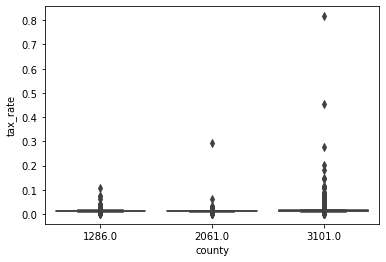

In [21]:
sns.boxplot(x=df["county"], y=df["tax_rate"],palette= 'Blues')

<AxesSubplot:xlabel='tax_rate'>

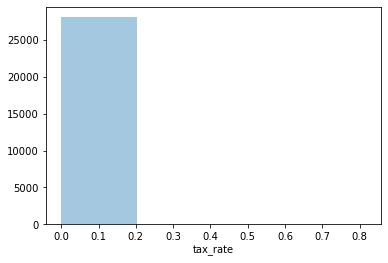

In [22]:
# Plot the histogram for tax_rate
sns.distplot( a=df["tax_rate"], bins=4, hist=True, kde=False, rug=False)

In [23]:
df.head()

,parcel_id,beds,baths,sqft,tax_value,taxamount,assessment_year,county,zipcode,fips,tranaction_date,tax_rate
0,11721753,3,2.0,1316.0,205123.0,2627.48,2016.0,3101.0,95997.0,6037.0,2017-07-21,0.012809
1,11289917,3,2.0,1458.0,136104.0,2319.90,2016.0,3101.0,97318.0,6037.0,2017-06-23,0.017045
2,11705026,2,1.0,1421.0,35606.0,543.69,2016.0,3101.0,96018.0,6037.0,2017-06-30,0.015270
3,14269464,4,3.0,2541.0,880456.0,9819.72,2016.0,1286.0,96958.0,6059.0,2017-06-01,0.011153
4,11446756,3,2.0,1491.0,107110.0,1399.27,2016.0,3101.0,96162.0,6037.0,2017-08-23,0.013064


In [24]:
# boxplot
#sns.boxplot(x=df["regionidcounty"], y=df["tax_rate"], kind='scatter')

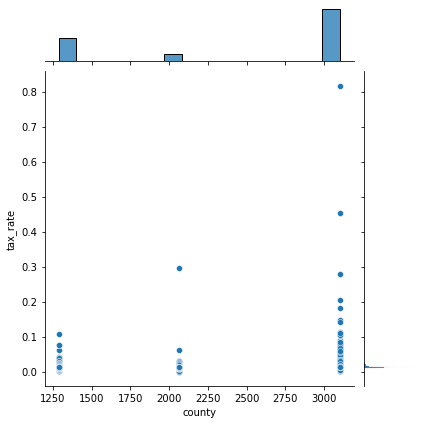

In [25]:
# here I would like to answer the stakeholders request for the distribution of tax_rate by county
sns.jointplot(x=df["county"], y=df["tax_rate"], kind='scatter')

so we can inform the stakeholders that in county 3101- Los Angeles the tax rate is the highest on average, followed by county 1286- Orange County and then the lowest tax_rate exists in Ventura 2061

In [26]:
# here is where I found the label for each county above
df.county.value_counts()

3101.0    17886
1286.0     7740
2061.0     2434
Name: county, dtype: int64

In [128]:
df.dtypes

parcel_id           object
beds                 int64
baths              float64
sqft               float64
tax_value           object
taxamount            int64
assessment_year     object
county              object
zipcode             object
fips               float64
tranaction_date     object
tax_rate           float64
dtype: object

In [27]:
df.shape

(28060, 12)

In [28]:
# time to check for duplicates and remove them
# dropping ALL duplicate values
df.drop_duplicates(subset ="parcel_id",
                     keep = False, inplace = True)
 

In [29]:
# here we can see with shape that numerous duplicate rows were dropped
df.shape

(28017, 12)

In [30]:
# let's get rid of the unnecessary decimal point
#df['beds','sqft','tax_value','assessment_year','county','zipcode'] = df['beds','sqft','tax_value','assessment_year','county','zipcode'].astype(str).apply(lambda x: x.replace('.0',''))
df['beds'] = df['beds'].astype(str).apply(lambda x: x.replace('.0',''))

In [31]:
df['sqft'] = df['sqft'].astype(str).apply(lambda x: x.replace('.0',''))

In [32]:
df['tax_value'] = df['tax_value'].astype(str).apply(lambda x: x.replace('.0',''))

In [33]:
df['assessment_year'] = df['assessment_year'].astype(str).apply(lambda x: x.replace('.0',''))

In [34]:
df['county'] = df['county'].astype(str).apply(lambda x: x.replace('.0',''))

In [35]:
df['zipcode'] = df['zipcode'].astype(str).apply(lambda x: x.replace('.0',''))

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28017 entries, 0 to 28123
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   parcel_id        28017 non-null  int64  
 1   beds             28017 non-null  object 
 2   baths            28017 non-null  float64
 3   sqft             28017 non-null  object 
 4   tax_value        28017 non-null  object 
 5   taxamount        28017 non-null  float64
 6   assessment_year  28017 non-null  object 
 7   county           28017 non-null  object 
 8   zipcode          28017 non-null  object 
 9   fips             28017 non-null  float64
 10  tranaction_date  28017 non-null  object 
 11  tax_rate         28017 non-null  float64
dtypes: float64(4), int64(1), object(7)
memory usage: 2.8+ MB


In [37]:
# check to see all decimals show how I would like
df.head()

,parcel_id,beds,baths,sqft,tax_value,taxamount,assessment_year,county,zipcode,fips,tranaction_date,tax_rate
0,11721753,3,2.0,1316,205123,2627.48,2016,3101,95997,6037.0,2017-07-21,0.012809
1,11289917,3,2.0,1458,136104,2319.90,2016,3101,97318,6037.0,2017-06-23,0.017045
2,11705026,2,1.0,1421,35606,543.69,2016,3101,96018,6037.0,2017-06-30,0.015270
3,14269464,4,3.0,2541,880456,9819.72,2016,1286,96958,6059.0,2017-06-01,0.011153
4,11446756,3,2.0,1491,107110,1399.27,2016,3101,96162,6037.0,2017-08-23,0.013064


In [38]:
# now let's tranform the columns back to the correct dtype
df.parcel_id = df.parcel_id.astype(object)

In [39]:
df.beds = df.beds.astype(int)

In [40]:
df.taxamount = df.taxamount.astype(int)

In [41]:
# here I am going to check for error values in the df
df.beds.value_counts()
# these seem reasonable for bedroom count so lets move on

3     12535
4      8266
2      4333
5      2138
6       340
1       311
7        50
0        30
8         7
9         4
10        2
11        1
Name: beds, dtype: int64

In [42]:
df.baths.value_counts()
# these numbers also seem reasonable for number of bathrooms

2.0     11693
3.0      5782
1.0      4895
2.5      2206
4.0      1195
3.5       538
1.5       451
5.0       440
4.5       384
6.0       174
5.5       111
7.0        51
8.0        29
6.5        27
0.0        23
7.5         9
9.0         5
11.0        2
10.0        1
8.5         1
Name: baths, dtype: int64

In [43]:
# changing the datatype back to a float
df.sqft = df.sqft.astype(float, copy=False)

In [44]:
# checking for any homes under 300 sqft because this could be an erroneous entry
df[df['sqft']< 300]

,parcel_id,beds,baths,sqft,tax_value,taxamount,assessment_year,county,zipcode,fips,tranaction_date,tax_rate
18533,11915330,0,1.0,240.0,380000,5222,2016,3101,96515,6037.0,2017-07-19,0.013743


In [45]:
# this only returned one location and this could be a tiny home so I have decided it is not an error value so I'll 
# keep it

In [46]:
# time to split up my df into train, validate, test and set my target
target = 'tax_value'

In [47]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.train_validate_test(df, target)

In [48]:
def train_validate_test(df, target):
    '''
    this function takes in a dataframe and splits it into 3 samples, 
    a test, which is 20% of the entire dataframe, 
    a validate, which is 24% of the entire dataframe,
    and a train, which is 56% of the entire dataframe. 
    It then splits each of the 3 samples into a dataframe with independent variables
    and a series with the dependent, or target variable. 
    The function returns train, validate, test sets and also another 3 dataframes and 3 series:
    X_train (df) & y_train (series), X_validate & y_validate, X_test & y_test. 
    '''
    # split df into test (20%) and train_validate (80%)
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)

    # split train_validate off into train (70% of 80% = 56%) and validate (30% of 80% = 24%)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=123)

        
    # split train into X (dataframe, drop target) & y (series, keep target only)
    X_train = train.drop(columns=[target])
    y_train = train[target]
    
    # split validate into X (dataframe, drop target) & y (series, keep target only)
    X_validate = validate.drop(columns=[target])
    y_validate = validate[target]
    
    # split test into X (dataframe, drop target) & y (series, keep target only)
    X_test = test.drop(columns=[target])
    y_test = test[target]
    
    return train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test

In [49]:
b = np.where(df.sqft < 300)
print(b)

(array([18450]),)


In [50]:
# now I am checking to make sure they are all the same shape col wise

(array([3.860e+02, 4.588e+03, 4.823e+03, 2.674e+03, 1.510e+03, 8.280e+02,
        4.130e+02, 1.920e+02, 8.900e+01, 7.300e+01, 3.700e+01, 3.300e+01,
        9.000e+00, 7.000e+00, 6.000e+00, 4.000e+00, 5.000e+00, 3.000e+00,
        2.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  240.        ,   806.83333333,  1373.66666667,  1940.5       ,
         2507.33333333,  3074.16666667,  3641.        ,  4207.83333333,
         4774.66666667,  5341.5       ,  5908.33333333,  6475.16666667,
         7042.        ,  7608.83333333,  8175.66666667,  8742.5       ,
         9309.33333333,  9876.16666667, 10443.        , 11009.83333333,
        11576.66666667, 12143.5       , 12710.33333333, 13277.16666667,
        13844.        , 14410.83333333, 14977.66666667, 15544.5       ,
        16111.33333333, 16678.16666667, 17245.        ]),
 <BarContainer object of 30 artists>)

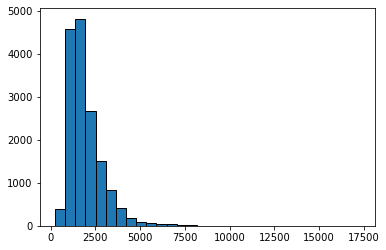

In [51]:
plt.hist(data=train, x='sqft', bins = 30,ec='black')

In [52]:
# Takeaway from dist plot, the squarefootage is pretty normally distributed

In [53]:
train.shape

(15689, 12)

In [54]:
validate.shape

(6724, 12)

In [55]:
test.shape

(5604, 12)

In [56]:
train[train['tax_value'] == train['tax_value'].max()]

,parcel_id,beds,baths,sqft,tax_value,taxamount,assessment_year,county,zipcode,fips,tranaction_date,tax_rate
15798,14327283,3,3.5,3792.0,999937,14352,2016,1286,96940,6059.0,2017-07-06,0.014354


In [57]:
train.tax_value.median()

379970.0

In [58]:
# now it's time to prep train2 for explore
train2 = train.copy()

In [59]:
#remove any column leaking the target so taxamount and tax_rate
train2 = train.drop(columns=['taxamount', 'tax_rate','tax_value'])


In [60]:
train2.head()

,parcel_id,beds,baths,sqft,assessment_year,county,zipcode,fips,tranaction_date
21624,13026423,4,4.0,3506.0,2016,3101,96486,6037.0,2017-08-01
13706,11083166,4,3.0,1914.0,2016,3101,96370,6037.0,2017-06-28
9146,12423929,3,2.0,1876.0,2016,3101,96204,6037.0,2017-06-09
963,13924568,3,3.0,1652.0,2016,1286,97026,6059.0,2017-05-04
26796,11414549,2,1.0,846.0,2016,3101,96135,6037.0,2017-08-28


<AxesSubplot:xlabel='beds'>

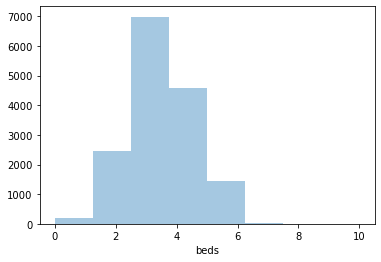

In [61]:
# Plot the histogram for beds
sns.distplot( a=train2["beds"], bins=8, hist=True, kde=False, rug=False )

<AxesSubplot:xlabel='sqft'>

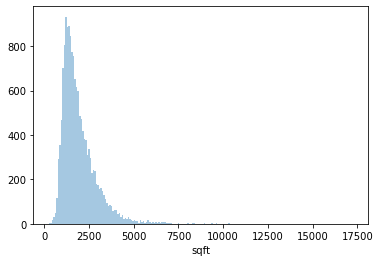

In [62]:
# Plot the histogram thanks to the distplot function
sns.distplot( a=train2["sqft"], bins=200, hist=True, kde=False, rug=False )

(array([2.000e+00, 1.020e+02, 1.189e+03, 3.247e+03, 3.220e+03, 2.384e+03,
        1.646e+03, 1.210e+03, 8.380e+02, 6.040e+02, 3.910e+02, 2.730e+02,
        1.710e+02, 1.030e+02, 7.700e+01, 4.500e+01, 4.300e+01, 3.300e+01,
        2.700e+01, 2.700e+01, 1.300e+01, 6.000e+00, 4.000e+00, 2.000e+00,
        9.000e+00, 1.000e+00, 4.000e+00, 1.000e+00, 5.000e+00, 1.000e+00]),
 array([    0.        ,   333.33333333,   666.66666667,  1000.        ,
         1333.33333333,  1666.66666667,  2000.        ,  2333.33333333,
         2666.66666667,  3000.        ,  3333.33333333,  3666.66666667,
         4000.        ,  4333.33333333,  4666.66666667,  5000.        ,
         5333.33333333,  5666.66666667,  6000.        ,  6333.33333333,
         6666.66666667,  7000.        ,  7333.33333333,  7666.66666667,
         8000.        ,  8333.33333333,  8666.66666667,  9000.        ,
         9333.33333333,  9666.66666667, 10000.        ]),
 <BarContainer object of 30 artists>)

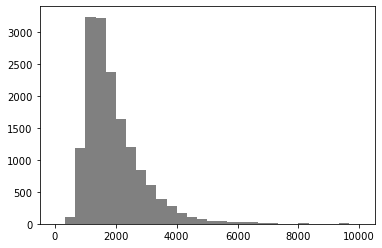

In [63]:
plt.hist(train2.sqft, 30, range=[0, 10000], facecolor='gray', align='mid')

Takeaway from distribution plot, they were all normally distributed.

<AxesSubplot:xlabel='county'>

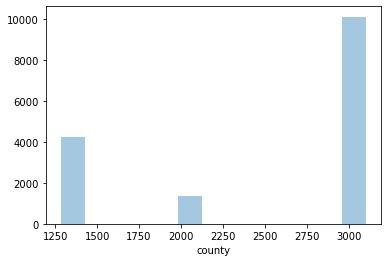

In [64]:
# Plot the histogram county
sns.distplot( a=train2["county"], hist=True, kde=False, rug=False )

Takeaway from histogram is that all of the homes fall in into 3 counties.

<AxesSubplot:xlabel='zipcode'>

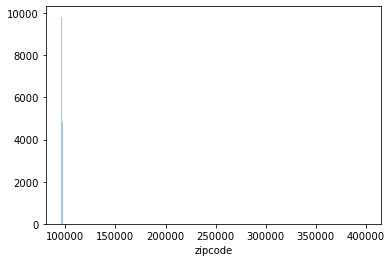

In [65]:
# Plot the histogram zipcode
sns.distplot( a=train2["zipcode"],bins=500,hist=True, kde=False, rug=False )

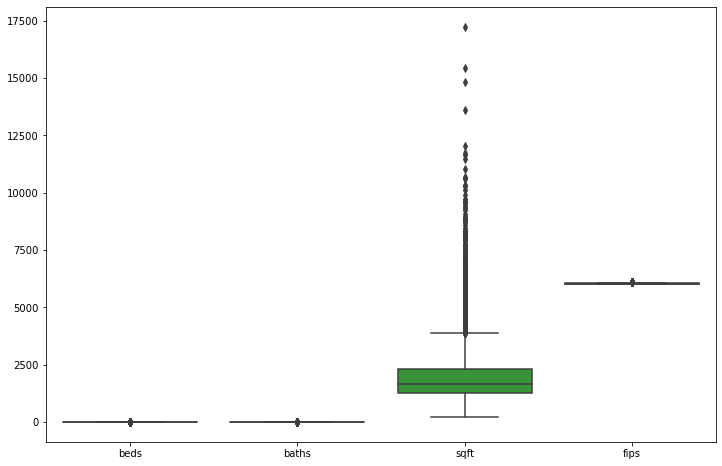

In [66]:
# We don't want to plot the 'pacel_id' column.

plt.figure(figsize=(12,8))

# Create boxplots for all but parcel_id, zipcode, tax_value, taxamount, tax_rate
sns.boxplot(data=df.drop(columns=['parcel_id','zipcode','tax_value','taxamount','tax_rate']))
plt.show()

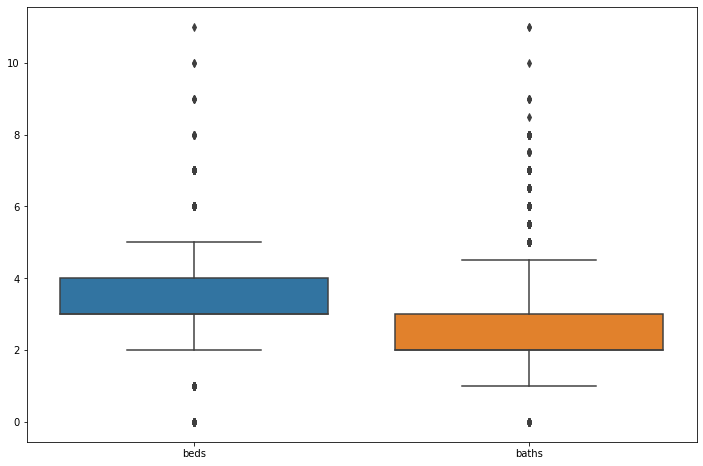

In [67]:
# create a boxplot for baths and beds so we can see them better
plt.figure(figsize=(12,8))

# Create boxplots for all but parcel_id.
sns.boxplot(data=df.drop(columns=['parcel_id','zipcode','tax_value','taxamount','sqft','tax_rate','fips']))
plt.show()

In [68]:
# time to scale
num_cols = ['beds','baths','sqft']
def use_min_max(X_train, X_validate, X_test, num_col):
    '''
    this function takes in X: train, validate, and test
    a list of numeric column names that were specified to use in the first go round of estimation,
    and fits a min-max scaler to the first dataframe only and then transforms all
    dataframes using this scaler. 
    it returns 3 dataframes with the same column names and scaled values. 
    '''
    # create the scaler object and fit it to X_train (i.e. identify min and max)
    # if copy = false, inplace row normalization happens and avoids a copy (if the input is already a numpy array).


    scaler = MinMaxScaler(copy=True).fit(X_train[num_cols])

    #scale X_train, X_validate, X_test using the mins and maxes stored in the scaler derived from X_train. 
    # 
    X_train_scaled_array = scaler.transform(X_train[num_cols])
    X_validate_scaled_array = scaler.transform(X_validate[num_cols])
    X_test_scaled_array = scaler.transform(X_test[num_cols])

    # convert arrays to dataframes
    X_train_scaled = pd.DataFrame(X_train_scaled_array, 
                                  columns=num_cols).\
                                  set_index([X_train.index.values])

    X_validate_scaled = pd.DataFrame(X_validate_scaled_array, 
                                     columns=num_cols).\
                                     set_index([X_validate.index.values])

    X_test_scaled = pd.DataFrame(X_test_scaled_array, 
                                 columns=num_cols).\
                                 set_index([X_test.index.values])

    
    return X_train_scaled, X_validate_scaled, X_test_scaled

In [69]:
use_min_max(X_train, X_validate, X_test, num_cols)

(       beds     baths      sqft
 21624   0.4  0.363636  0.192061
 13706   0.4  0.272727  0.098442
 9146    0.3  0.181818  0.096207
 963     0.3  0.272727  0.083034
 26796   0.2  0.090909  0.035637
 ...     ...       ...       ...
 2565    0.3  0.181818  0.058689
 6669    0.5  0.181818  0.103969
 16333   0.4  0.272727  0.109380
 12982   0.4  0.272727  0.070626
 5949    0.3  0.181818  0.070097
 
 [15689 rows x 3 columns],
        beds     baths      sqft
 20336   0.3  0.272727  0.113790
 16156   0.1  0.181818  0.059688
 9767    0.3  0.272727  0.164716
 8852    0.4  0.272727  0.111144
 22535   0.3  0.181818  0.070567
 ...     ...       ...       ...
 24514   0.3  0.090909  0.100911
 25652   0.3  0.181818  0.064510
 9188    0.3  0.181818  0.075331
 17165   0.5  0.272727  0.115907
 4254    0.2  0.090909  0.061041
 
 [6724 rows x 3 columns],
        beds     baths      sqft
 12450   0.5  0.454545  0.187063
 712     0.3  0.181818  0.068098
 2281    0.4  0.363636  0.169832
 8922    0.4  0.454

##Takeaways from Prepare
df is prepped and ready to answer questions posed
X_train, etc. is prepped and ready for explore
there were no outliers in the dataset after cleaning and whittling it down

examples
exam1 has 1 Null value.
exam1 should likely be of type int64 once the Null value is addressed.
There is likely an odd value in exam3, as it should be of type int64 but was read in as an object. We need to find that value.
Given that there are limited attributes and limited observations with missing values, dropping the observations with missing values is probably a good way to go here

In [70]:
train.tax_value.mean()

inf

In [71]:
######## EXPLORE ############

Hypothesis 1: Let's see if there is a relationship between sqft and tax_value.

alpha = .05

$H_0$: There is no relationship between sqft and tax_value, they are independent. 

$H_a$: There is a relationship between sqft and tax_value, they are dependent on each other.



Hypothesis 2: Let's see if there is a relationship between baths and tax_value.

alpha = .05

$H_0$: There is no relationship between baths and tax_value, they are independent. 

$H_a$: There is a relationship between baths and tax_value, they are dependent on each other.



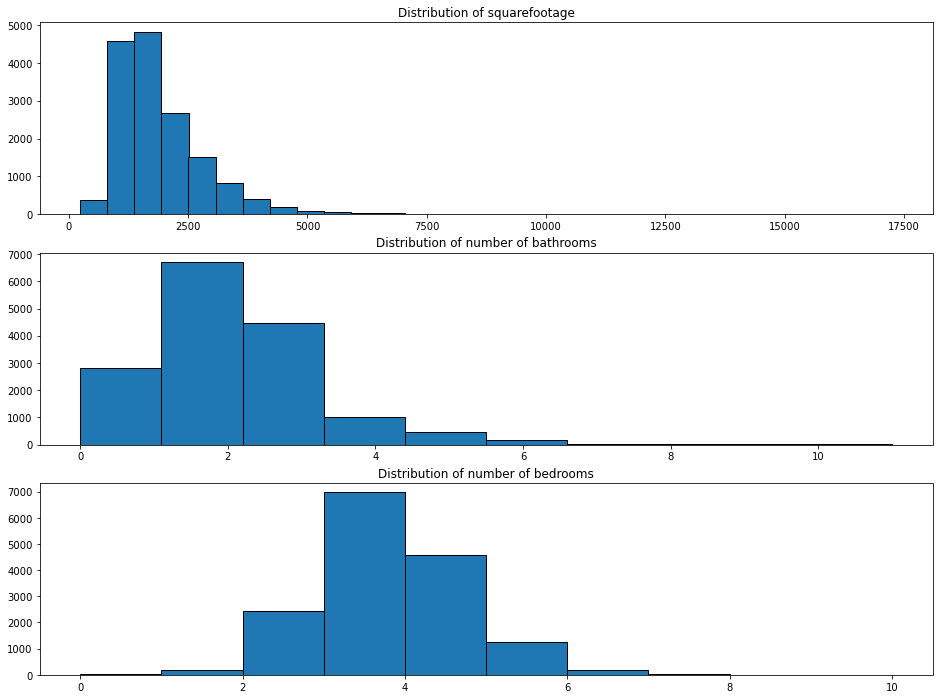

In [72]:
# plot histograms
plt.figure(figsize=(16,12))
plt.subplot(3,1,1, title='Distribution of squarefootage')
plt.hist(data=train2, x='sqft', bins = 30,ec='black')

plt.subplot(3,1,2, title='Distribution of number of bathrooms')
plt.hist(data=train2, x='baths', ec='black')

plt.subplot(3,1,3, title='Distribution of number of bedrooms')
plt.hist(data=train2, x='beds',ec='black')

plt.show()

Takeaway from histograms beds, baths and sqft all normally distributed

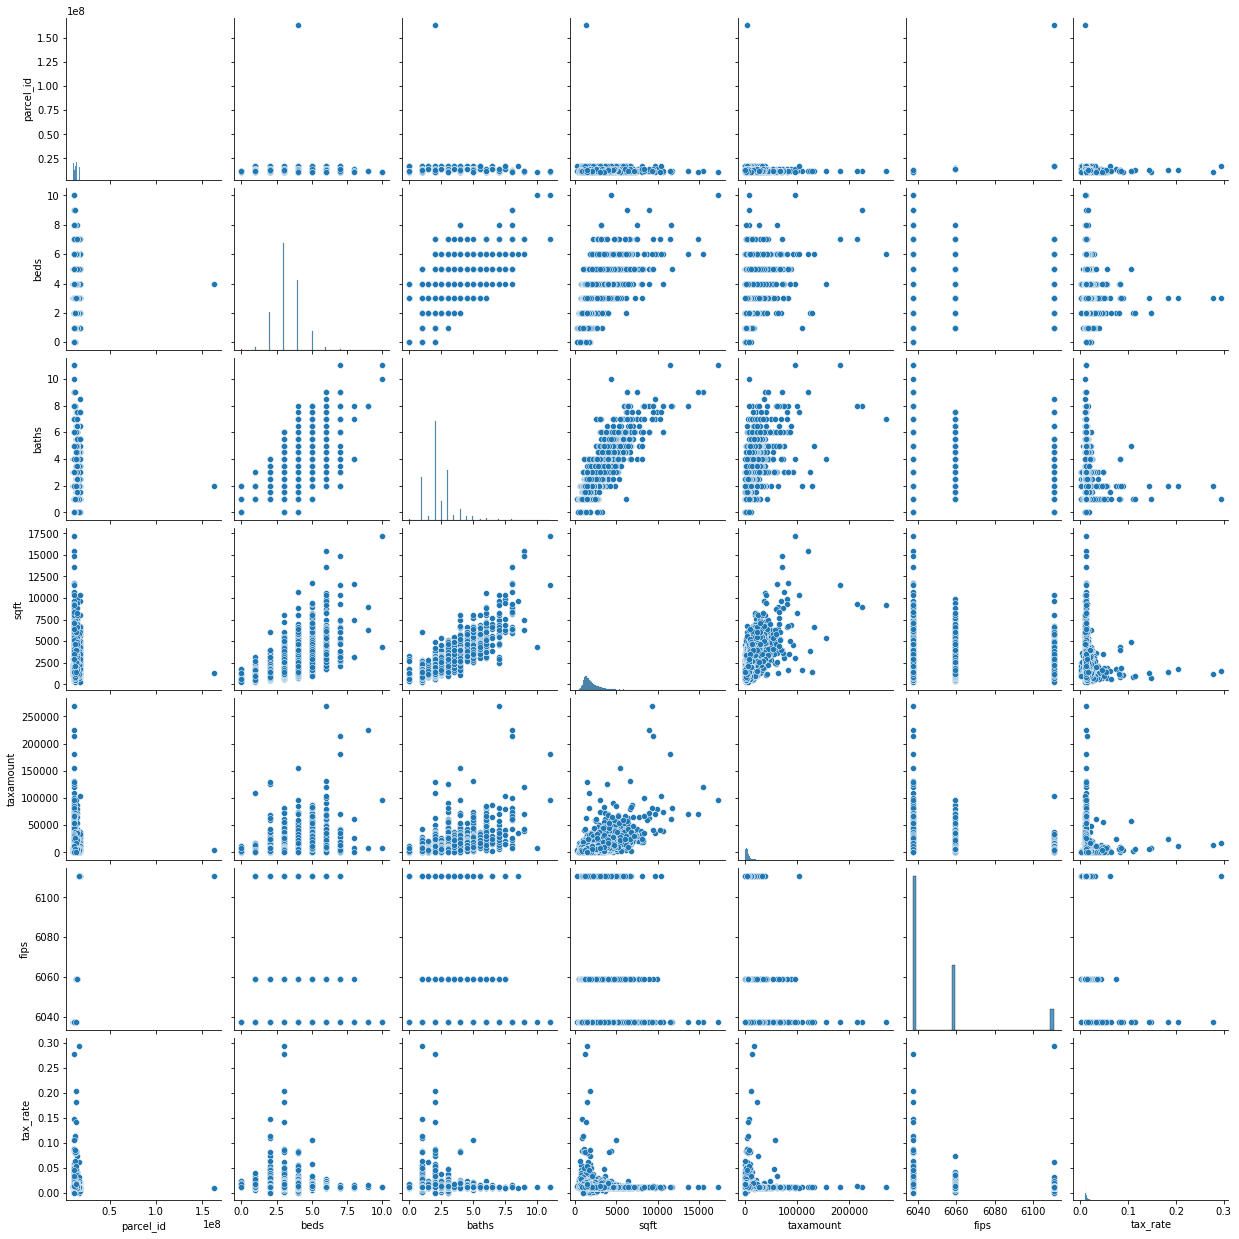

In [73]:
#make a pairpolot
sns.pairplot(train)

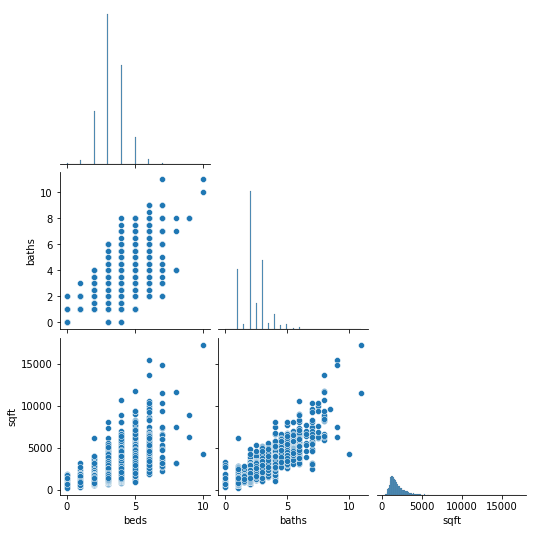

In [74]:
#Let's use sns.pairplot() to view a scatter plot visualizing the relationships between all of the numeric columns in our dataset all at once as well as individual distributions for each individual column.

# We can drop the redundant information in the upper right half of the chart if we like.

sns.pairplot(train[['beds', 'baths', 'sqft', 'tax_value']], corner=True)
plt.show()

** Takeaway from pair plot


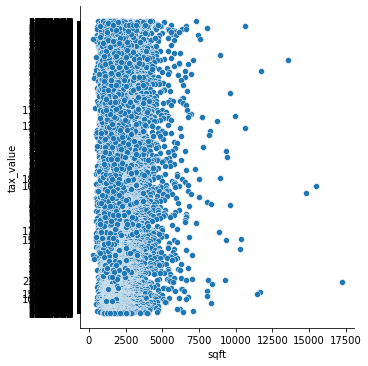

In [75]:
# Let's do a simple scatter plot of two continuous variables in our dataset.

sns.relplot(x="sqft", y="tax_value", data=train)
plt.show()

In [76]:
train2 = train2.drop(columns='fips')

In [77]:
# create a correlation table
train2.corr()

,beds,baths,sqft
beds,1.000000,0.645160,0.628078
baths,0.645160,1.000000,0.849462
sqft,0.628078,0.849462,1.000000


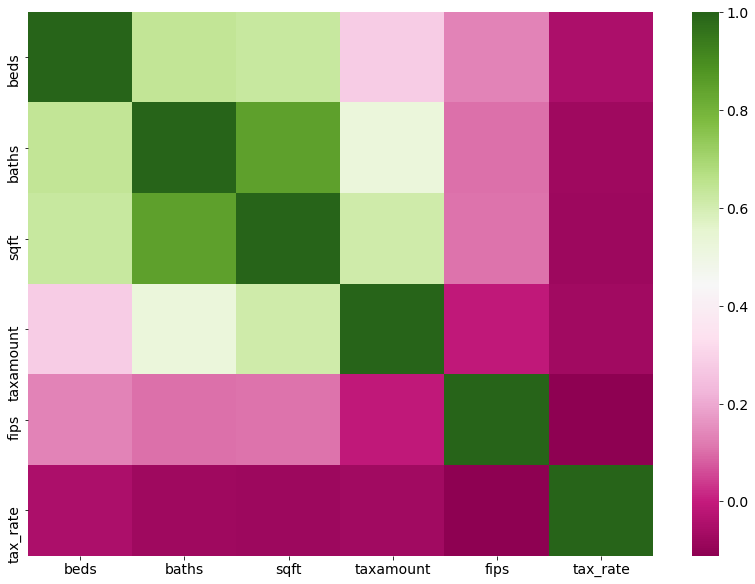

In [78]:
plt.rc('font', size=14)
plt.rc('figure', figsize=(14, 10))
sns.heatmap(df.corr(), cmap='PiYG')
#sns.heatmap(train2.corr(), cmap='mako', center=0, annot=True)
plt.show()

In [79]:
# the heatmap shows me there is strong correlation between baths and sqft

In [80]:
train.tax_value = train.tax_value.astype(float)

In [81]:
y_train.head()

21624    613741
13706     98329
9146     442649
963      244903
26796    330000
Name: tax_value, dtype: object

In [82]:
train.head()

,parcel_id,beds,baths,sqft,tax_value,taxamount,assessment_year,county,zipcode,fips,tranaction_date,tax_rate
21624,13026423,4,4.0,3506.0,613741.0,7188,2016,3101,96486,6037.0,2017-08-01,0.011712
13706,11083166,4,3.0,1914.0,98329.0,1352,2016,3101,96370,6037.0,2017-06-28,0.013751
9146,12423929,3,2.0,1876.0,442649.0,5235,2016,3101,96204,6037.0,2017-06-09,0.011827
963,13924568,3,3.0,1652.0,244903.0,2475,2016,1286,97026,6059.0,2017-05-04,0.010110
26796,11414549,2,1.0,846.0,330000.0,4574,2016,3101,96135,6037.0,2017-08-28,0.013863


In [83]:
# Create the correlation matrix for all features.

exam_corr = train.drop(columns=['parcel_id','taxamount','assessment_year','county','zipcode','tranaction_date','tax_rate']).corr()
exam_corr

,beds,baths,sqft,tax_value,fips
beds,1.000000,0.645160,0.628078,0.284182,0.128928
baths,0.645160,1.000000,0.849462,0.530350,0.102519
sqft,0.628078,0.849462,1.000000,0.615376,0.103555
tax_value,0.284182,0.530350,0.615376,1.000000,0.019977
fips,0.128928,0.102519,0.103555,0.019977,1.000000


In [84]:
exam_corr.dtypes

beds         float64
baths        float64
sqft         float64
tax_value    float64
fips         float64
dtype: object

In [85]:
# Use a scipy stats function pearsonr to calculate the correlation coefficient and the p-value.

r, p_value = pearsonr(train.baths, train.tax_value)
print(r, p_value)

0.5303504745475505 0.0


Based on my correlation coefficient and my p-value, I reject my Null hypothesis 2 that there is no correlation 
between baths and tax_value.

In [86]:
# Use a scipy stats function pearsonr to calculate the correlation coefficient and the p-value.

r, p_value = pearsonr(train.sqft, train.tax_value)
print(r, p_value)

0.6153757320244508 0.0


In [87]:
# Based on my correlation coefficient and my p-value, I reject my Null hypothesis 1 that there is no correlation 
# between sqft and tax_value.

In [88]:
# # Since my variables are not normally distributed, I might choose Spearman instead.

# value_spearman = train.drop(columns=['tax_value','taxamount','tax_rate']).corr(method='spearman')
# value_spearman

In [89]:
#sns.relplot(data=train2, x='baths', y='sqft', kind='scatter',col=y_train)

In [90]:
# Next I'll display some pairplots
# sns.pairplot(X_train, hue=y_train)
# plt.show()

In [91]:
### Univariate

def explore_univariate_categorical(train, cat_var):
    '''
    takes in a dataframe and a categorical variable and returns
    a frequency table and barplot of the frequencies. 
    '''
    frequency_table = freq_table(train, cat_var)
    plt.figure(figsize=(2,2))
    sns.barplot(x=cat_var, y='Count', data=frequency_table, color='lightseagreen')
    plt.title(cat_var)
    plt.show()
    print(frequency_table)

def explore_univariate_quant(train, quant_var):
    '''
    takes in a dataframe and a quantitative variable and returns
    descriptive stats table, histogram, and boxplot of the distributions. 
    '''
    descriptive_stats = train[quant_var].describe()
    plt.figure(figsize=(8,2))

    p = plt.subplot(1, 2, 1)
    p = plt.hist(train[quant_var], color='lightseagreen')
    p = plt.title(quant_var)

    # second plot: box plot
    p = plt.subplot(1, 2, 2)
    p = plt.boxplot(train[quant_var])
    p = plt.title(quant_var)
    return p, descriptive_stats
    
def freq_table(train, cat_var):
    '''
    for a given categorical variable, compute the frequency count and percent split
    and return a dataframe of those values along with the different classes. 
    '''
    class_labels = list(train[cat_var].unique())

    frequency_table = (
        pd.DataFrame({cat_var: class_labels,
                      'Count': train[cat_var].value_counts(normalize=False), 
                      'Percent': round(train[cat_var].value_counts(normalize=True)*100,2)}
                    )
    )
    return frequency_table

In [92]:
def explore_univariate(train, cat_vars, quant_vars):
    for var in cat_vars:
        explore_univariate_categorical(train, var)
        print('_________________________________________________________________')
    for col in quant_vars:
        p, descriptive_stats = explore_univariate_quant(train, col)
        plt.show(p)
        print(descriptive_stats)

In [93]:
train.head()

,parcel_id,beds,baths,sqft,tax_value,taxamount,assessment_year,county,zipcode,fips,tranaction_date,tax_rate
21624,13026423,4,4.0,3506.0,613741.0,7188,2016,3101,96486,6037.0,2017-08-01,0.011712
13706,11083166,4,3.0,1914.0,98329.0,1352,2016,3101,96370,6037.0,2017-06-28,0.013751
9146,12423929,3,2.0,1876.0,442649.0,5235,2016,3101,96204,6037.0,2017-06-09,0.011827
963,13924568,3,3.0,1652.0,244903.0,2475,2016,1286,97026,6059.0,2017-05-04,0.010110
26796,11414549,2,1.0,846.0,330000.0,4574,2016,3101,96135,6037.0,2017-08-28,0.013863


In [94]:
cat_vars = ['zipcode','county']
quant_vars = ['beds','baths','sqft']

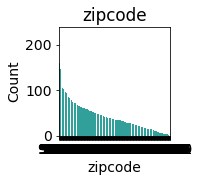

      zipcode  Count  Percent
97319   96486    227     1.45
97318   96370    185     1.18
97329   96204    160     1.02
97118   97026    157     1.00
97328   96135    153     0.98
...       ...    ...      ...
96467   96136      1     0.01
97108   96207      1     0.01
96226   96151      1     0.01
96002   96002      1     0.01
96001   97109      1     0.01

[373 rows x 3 columns]
_________________________________________________________________


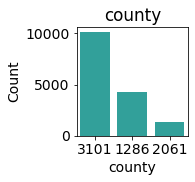

     county  Count  Percent
3101   3101  10099    64.37
1286   1286   4245    27.06
2061   2061   1345     8.57
_________________________________________________________________


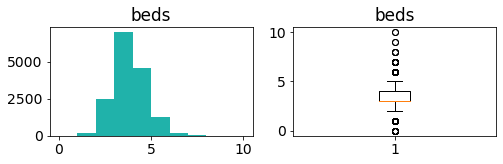

count    15689.000000
mean         3.316400
std          0.935019
min          0.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         10.000000
Name: beds, dtype: float64


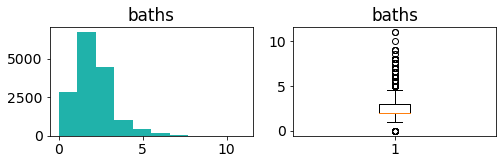

count    15689.000000
mean         2.317802
std          1.018159
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         11.000000
Name: baths, dtype: float64


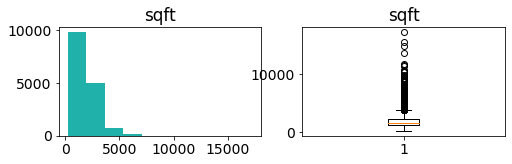

count    15689.000000
mean      1935.164128
std       1002.002152
min        240.000000
25%       1276.000000
50%       1677.000000
75%       2328.000000
max      17245.000000
Name: sqft, dtype: float64


In [95]:
explore_univariate(train, cat_vars, quant_vars)

In [96]:
# bivariate

In [97]:
#### Bivariate
target = 'tax_value'
def explore_bivariate_categorical(train, target, cat_var):
    '''
    takes in categorical variable and binary target variable, 
    returns a crosstab of frequencies
    runs a chi-square test for the proportions
    and creates a barplot, adding a horizontal line of the overall rate of the target. 
    '''
    print(cat_var, "\n_____________________\n")
    ct = pd.crosstab(train[cat_var], train[target], margins=True)
    chi2_summary, observed, expected = run_chi2(train, cat_var, target)
    p = plot_cat_by_target(train, target, cat_var)
    
    print(chi2_summary)
    print("\nobserved:\n", ct)
    print("\nexpected:\n", expected)
    plt.show(p)
    print("\n_____________________\n")

def explore_bivariate_quant(train, target, quant_var):
    '''
    descriptive stats by each target class. 
    compare means across 2 target groups 
    boxenplot of target x quant
    swarmplot of target x quant
    '''
    print(quant_var, "\n____________________\n")
    descriptive_stats = train.groupby(target)[quant_var].describe()
    average = train[quant_var].mean()
    mann_whitney = compare_means(train, target, quant_var)
    plt.figure(figsize=(4,4))
    boxen = plot_boxen(train, target, quant_var)
    swarm = plot_swarm(train, target, quant_var)
    plt.show()
    print(descriptive_stats, "\n")
    print("\nMann-Whitney Test:\n", mann_whitney)
    print("\n____________________\n")

## Bivariate Categorical

def run_chi2(train, cat_var, target):
    observed = pd.crosstab(train[cat_var], train[target])
    chi2, p, degf, expected = stats.chi2_contingency(observed)
    chi2_summary = pd.DataFrame({'chi2': [chi2], 'p-value': [p], 
                                 'degrees of freedom': [degf]})
    expected = pd.DataFrame(expected)
    return chi2_summary, observed, expected

def plot_cat_by_target(train, target, cat_var):
    p = plt.figure(figsize=(2,2))
    p = sns.barplot(cat_var, target, data=train, alpha=.8, color='lightseagreen')
    overall_rate = train[target].mean()
    p = plt.axhline(overall_rate, ls='--', color='gray')
    return p
    

## Bivariate Quant

def plot_swarm(train, target, quant_var):
    average = train[quant_var].mean()
    p = sns.swarmplot(data=train, x=target, y=quant_var, color='lightgray')
    p = plt.title(quant_var)
    p = plt.axhline(average, ls='--', color='black')
    return p

def plot_boxen(train, target, quant_var):
    average = train[quant_var].mean()
    p = sns.boxenplot(data=train, x=target, y=quant_var, color='lightseagreen')
    p = plt.title(quant_var)
    p = plt.axhline(average, ls='--', color='black')
    return p

# alt_hyp = ‘two-sided’, ‘less’, ‘greater’

def compare_means(train, target, quant_var, alt_hyp='two-sided'):
    x = train[train[target]==0][quant_var]
    y = train[train[target]==1][quant_var]
    return stats.mannwhitneyu(x, y, use_continuity=True, alternative=alt_hyp)

def explore_bivariate(train, target, cat_vars, quant_vars):
    for cat in cat_vars:
        explore_bivariate_categorical(train, target, cat)
    for quant in quant_vars:
        explore_bivariate_quant(train, target, quant)


In [98]:
#explore_bivariate(train, target, cat_vars, quant_vars)

In [99]:
# the results of the bivariate 
# chi2 test shows a very low p value indicating a very likely correlation between baths and tax_value

In [100]:
# check for relationship between zipcode and tax_value
run_chi2(train, 'zipcode', target)

(           chi2       p-value  degrees of freedom
 0  5.075454e+06  1.577880e-45             5030556,
 tax_value  11089.0     13199.0     13616.0     13820.0     14284.0     \
 zipcode                                                                 
 399675              0           0           0           0           0   
 95982               0           1           0           0           0   
 95983               0           0           0           0           0   
 95984               0           0           1           0           0   
 95985               0           0           0           0           0   
 ...               ...         ...         ...         ...         ...   
 97328               0           0           0           0           0   
 97329               0           0           0           0           0   
 97330               0           0           0           0           0   
 97331               0           0           0           0           0   
 97344   

In [101]:
# chi2 test shows a very low p value indicating a very likely correlation between zipcode and tax_value

In [102]:
# check for relationship between county and tax_value
run_chi2(train, 'county', target)

(           chi2       p-value  degrees of freedom
 0  28203.814833  4.513480e-07               27046,
 tax_value  11089.0     13199.0     13616.0     13820.0     14284.0     \
 county                                                                  
 1286                0           0           0           0           0   
 2061                0           0           0           0           0   
 3101                1           1           1           1           1   
 
 tax_value  14439.0     15433.0     16317.0     18584.0     18589.0     ...  \
 county                                                                 ...   
 1286                0           0           0           0           0  ...   
 2061                0           1           0           0           0  ...   
 3101                1           0           1           1           1  ...   
 
 tax_value  9837578.0   10071018.0  10873908.0  11000000.0  11020600.0  \
 county                                               

In [103]:
# chi2 test shows a very low p value indicating a very likely correlation between county and tax_value

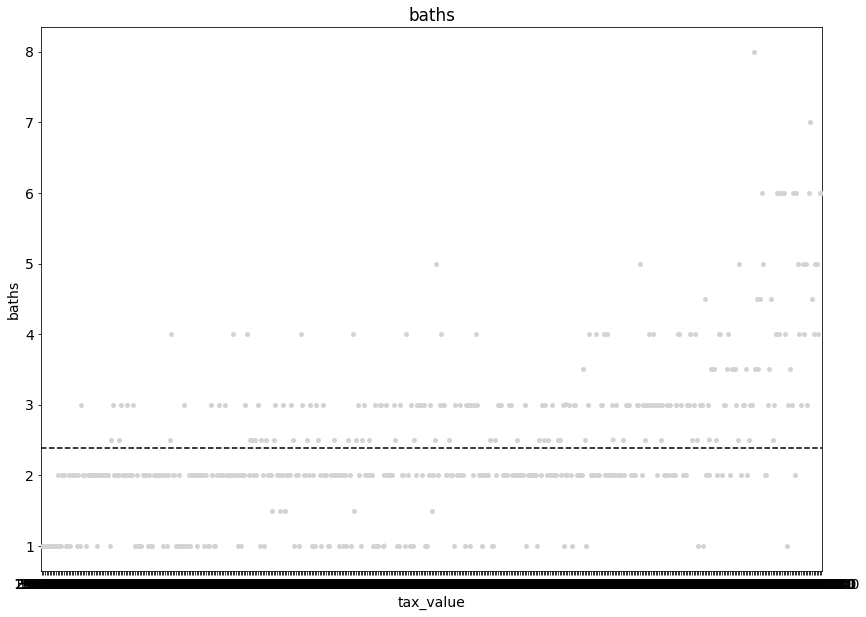

In [104]:
plot_swarm(train.head(500), target, 'baths')

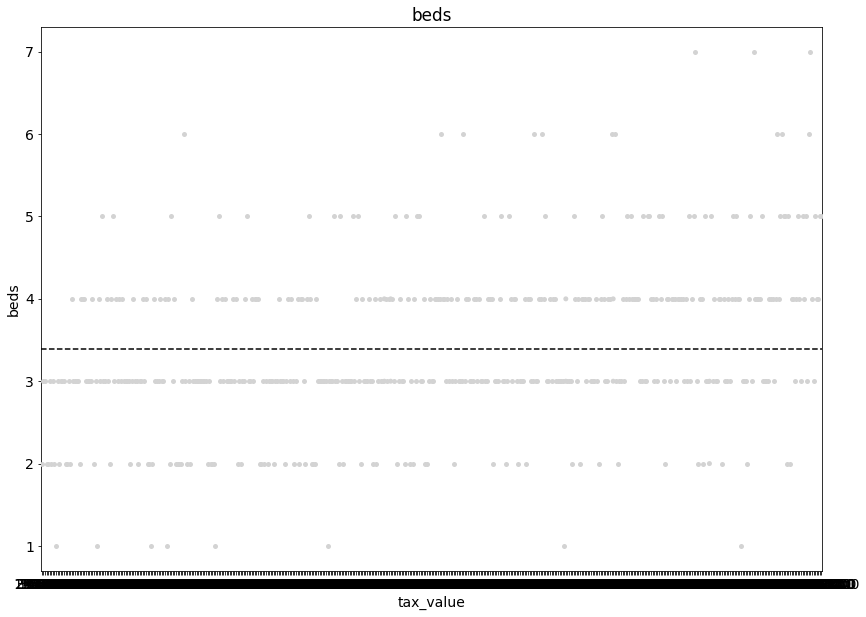

In [105]:
plot_swarm(train.head(500), target, 'beds')

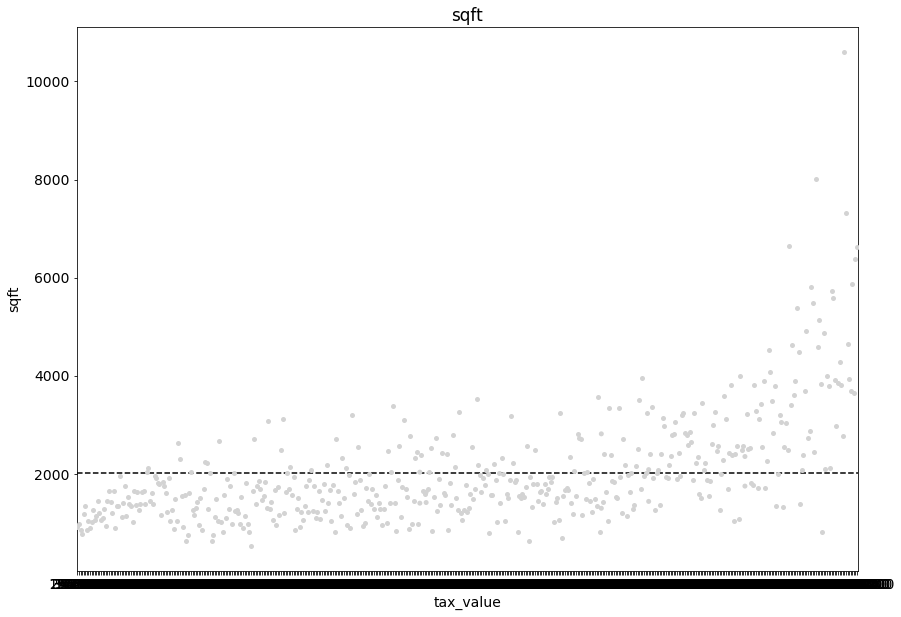

In [106]:
plot_swarm(train.head(500), target, 'sqft')

In [107]:
## multivariate

In [108]:
## Multivariate

def plot_all_continuous_vars(train, target, quant_vars):
    '''
    Melt the dataset to "long-form" representation
    boxenplot of measurement x value with color representing the target variable. 
    '''
    my_vars = [item for sublist in [quant_vars, [target]] for item in sublist]
    sns.set(style="whitegrid", palette="muted")
    melt = train[my_vars].melt(id_vars=target, var_name="measurement")
    plt.figure(figsize=(8,6))
    p = sns.boxenplot(x="measurement", y="value", hue=target, data=melt)
    p.set(yscale="log", xlabel='')    
    plt.show()

def plot_violin_grid_with_color(train, target, cat_vars, quant_vars):
    cols = len(cat_vars)
    for quant in quant_vars:
        _, ax = plt.subplots(nrows=1, ncols=cols, figsize=(16, 4), sharey=True)
        for i, cat in enumerate(cat_vars):
            sns.violinplot(x=cat, y=quant, data=train, split=True, 
                           ax=ax[i], hue=target, palette="Set2")
            ax[i].set_xlabel('')
            ax[i].set_ylabel(quant)
            ax[i].set_title(cat)
        plt.show()
    
def plot_swarm_grid_with_color(train, target, cat_vars, quant_vars):
    cols = len(cat_vars)
    for quant in quant_vars:
        _, ax = plt.subplots(nrows=1, ncols=cols, figsize=(16, 4), sharey=True)
        for i, cat in enumerate(cat_vars):
            sns.swarmplot(x=cat, y=quant, data=train, ax=ax[i], hue=target, palette="Set2")
            ax[i].set_xlabel('')
            ax[i].set_ylabel(quant)
            ax[i].set_title(cat)
        plt.show()

In [109]:
def explore_multivariate(train, target, cat_vars, quant_vars):
    '''
    '''
    plot_swarm_grid_with_color(train, target, cat_vars, quant_vars)
    plt.show()
    violin = plot_violin_grid_with_color(train, target, cat_vars, quant_vars)
    plt.show()
    pair = sns.pairplot(data=train, vars=quant_vars, hue=target)
    plt.show()
    plot_all_continuous_vars(train, target, quant_vars)
    plt.show()    


In [110]:
#explore_multivariate(train, target, cat_vars, quant_vars)

In [111]:
# # Next I'll display some pairplots
# sns.pairplot(train, hue='tax_value')
# plt.show()

** Takeaways from explore





In [112]:
#################################### Modeling ################################################

In [113]:
# #scaled df
# X_train_scaled, X_validate_scaled, X_test_scaled = min_max_scale(X_train, X_validate, X_test, num_cols)

In [114]:
y_train =y_train.astype(float)

In [115]:
# establish the baseline

In [116]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict tax_value_pred_mean
tax_value_pred_mean = y_train['tax_value'].mean()
y_train['tax_value_pred_mean'] = tax_value_pred_mean
y_validate['tax_value_pred_mean'] = tax_value_pred_mean

# 2. compute tax_value_pred_median
tax_value_pred_median = y_train['tax_value'].median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median

# 3. RMSE of tax_value_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  692709.66 
Validate/Out-of-Sample:  743878.34


In [117]:
X_train = X_train.drop(columns=['parcel_id','taxamount','assessment_year','county','tranaction_date','tax_rate','zipcode'])
X_validate = X_validate.drop(columns=['parcel_id','taxamount','assessment_year','county','tranaction_date','tax_rate','zipcode'])

In [118]:
# Fit a LinearRegression model using the features suggested in the curriculum
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm)**(1/2)

# predict validate
y_validate['tax_value_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  536650.6442200879 
Validation/Out-of-Sample:  578409.619489961


In [119]:
#LassoLars model
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars)**(1/2)

# predict validate
y_validate['tax_value_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  536650.7473926865 
Validation/Out-of-Sample:  578416.0715188411


In [120]:
# Find model error to determine best model


#baseline error
Train/In-Sample:  692709.66 
Validate/Out-of-Sample:  743878.34

#RMSE for OLS using LinearRegression
Training/In-Sample:  537153.0834869705 
Validation/Out-of-Sample:  579157.4368710583

#RMSE for Lasso + Lars
Training/In-Sample:  537153.1735234142 
Validation/Out-of-Sample:  579162.4635582954

OLS_train_error =537153.0834869705 
OLS_validate_error=579157.4368710583
LSLRS_train_error =537153.1735234142 
LSLRS_validate_error=579162.4635582954

LSLRS_train_error - OLS_train_error

LSLRS_validate_error - OLS_validate_error

In [121]:
# So OLS has less error in train and validate and is our best model

In [122]:
# Now let's see how OLS performs on the test

In [123]:
X_test = X_test.drop(columns=['parcel_id','taxamount','assessment_year','county','tranaction_date','tax_rate','zipcode'])

In [124]:
X_test.head()

,beds,baths,sqft,fips
12450,5,5.0,3421.0,6037.0
712,3,2.0,1398.0,6037.0
2281,4,4.0,3128.0,6037.0
8922,4,5.0,4218.0,6037.0
26594,3,2.0,1244.0,6037.0


In [125]:
# Model Selection & Out-of-Sample Evaluation
# Model selected: lm (using LinearRegression)
    
y_test = pd.DataFrame(y_test)

# predict on test
y_test['tax_value_pred_lm'] = lm.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_value_pred_lm) ** (1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)

RMSE for OLS Model using LinearRegression
Out-of-Sample Performance:  535190.5014027276


TO DO

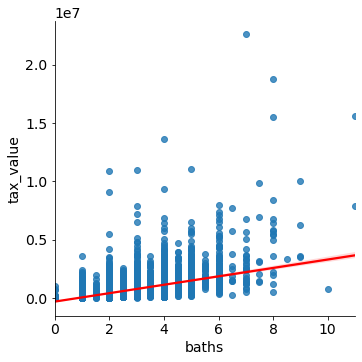

In [126]:
# A simple scatter plot with the regression line

sns.lmplot(x="baths", y="tax_value", data=train, line_kws={'color': 'red'})
plt.show()

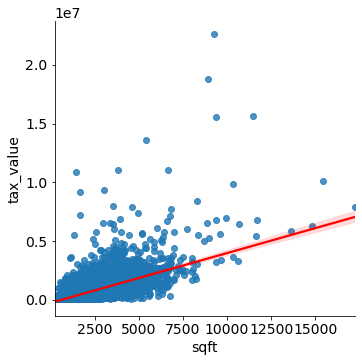

In [127]:
#Let's make a simple scatter plot but add a regression line.

sns.lmplot(x="sqft", y="tax_value", data=train, line_kws={'color': 'red'})
plt.show()

Takeaways from scatter plots is that there is a linear relationship between sqft and tax_value and also between baths and tax_value